In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Our image processing tools
import skimage.filters
import skimage.io
import skimage.measure
import skimage.morphology



In [2]:
def gfp_segmenter(im_phase, im_gfp):

    ip_distance = 0.3774415 # specific to our microscope (BZ‐X800)
    
    # Get the physical scale of the image in terms of interpixel distance
    dw = im_phase.shape[1] * ip_distance
    dh = im_phase.shape[0] * ip_distance

    # Apply a Gaussian blur with a 50 pixel radius.
    im_phase_gauss = skimage.filters.gaussian(im_phase, 50.0)
    
    # Convert median filtered image to float
    im_phase_float = skimage.img_as_float(im_phase)

    # Subtract our gaussian blurred image from the original.
    im_phase_sub = im_phase_float - im_phase_gauss

    # Perform a Chambolle total variation filter.
    im_phase_tv = skimage.restoration.denoise_tv_chambolle(
                                                im_phase_sub, weight=0.005)

    # Construct thresholded image
    im_bw = im_phase_tv < -0.1 # the threshold we chose after analyzing a few images individually

    # Clear border with 5 pixel buffer
    im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)

    # Label binary image; background kwarg says value in im_bw to be background
    im_labeled, n_labels = skimage.measure.label(im_bw, background=0, return_num=True)

    # Show number of regions
    # print("Number of individual regions = ", n_labels)

    # Extract region props
    im_props = skimage.measure.regionprops(
        im_labeled,
        intensity_image=im_gfp,
    )

    # Make a filtered black and white image
    im_bw_filt = im_labeled > 0
    
    # Define the cutoff size
    cutoff = 7
    
    # Loop through image properties and delete small objects
    n_regions = 0
    for prop in im_props:
        if prop.area < cutoff:
            im_bw_filt[im_labeled==prop.label] = 0
        else:
            n_regions += 1
    
    # Show number of regions
    # print('Number of individual regions = ', n_regions)

    # Loop through image properties and delete small objects and round objects
    n_regions = 0
    for prop in im_props:
        if prop.area < cutoff or prop.eccentricity < 0.85:
            im_bw_filt[im_labeled==prop.label] = 0
        else:
            n_regions += 1
    
    # Show number of regions
    # print('Number of individual regions = ', n_regions)

    # Initialize list of intensities of individual bacteria
    mean_intensity = []
    
    # Loop through regions and compute mean intensity of bacteria
    for prop in im_props:
        if prop.area > cutoff and prop.eccentricity > 0.8:
            mean_intensity.append(prop.mean_intensity)
    
    # Convert list to NumPy array
    mean_intensity = np.array(mean_intensity)



    return mean_intensity



In [3]:
sp_directory_list = ['sp_cm_1', 'sp_cm_2', 'sp_cm_3', 'sp_cm_4', 'sp_cm_5',
                    'sp_cm+atc_1', 'sp_cm+atc_2', 'sp_cm+atc_3', 'sp_cm+atc_4', 'sp_cm+atc_5',
                    'sp_cm+kan_1', 'sp_cm+kan_2', 'sp_cm+kan_3', 'sp_cm+kan_4', 'sp_cm+kan_5',
                    'sp_cm+kan+atc_1', 'sp_cm+kan+atc_2', 'sp_cm+kan+atc_3', 'sp_cm+kan+atc_4', 'sp_cm+kan+atc_5']

Msp1_directory_list = ['Msp1_cm_1', 'Msp1_cm_2', 'Msp1_cm_3', 'Msp1_cm_4', 'Msp1_cm_5',
                    'Msp1_cm+atc_1', 'Msp1_cm+atc_2', 'Msp1_cm+atc_3', 'Msp1_cm+atc_4', 'Msp1_cm+atc_5',
                    'Msp1_cm+kan_1', 'Msp1_cm+kan_2', 'Msp1_cm+kan_3', 'Msp1_cm+kan_4', 'Msp1_cm+kan_5',
                    'Msp1_cm+kan+atc_1', 'Msp1_cm+kan+atc_2', 'Msp1_cm+kan+atc_3', 'Msp1_cm+kan+atc_4', 'Msp1_cm+kan+atc_5']

constitutive_gfp_directory_list = ['const_cm_1', 'const_cm_2', 'const_cm_3', 'const_cm_4', 'const_cm_5',
                    'const_cm+atc_1', 'const_cm+atc_2', 'const_cm+atc_3', 'const_cm+atc_4', 'const_cm+atc_5',
                    'const_cm+kan_1', 'const_cm+kan_2', 'const_cm+kan_3', 'const_cm+kan_4', 'const_cm+kan_5',
                    'const_cm+kan+atc_1', 'const_cm+kan+atc_2', 'const_cm+kan+atc_3', 'const_cm+kan+atc_4', 'const_cm+kan+atc_5']


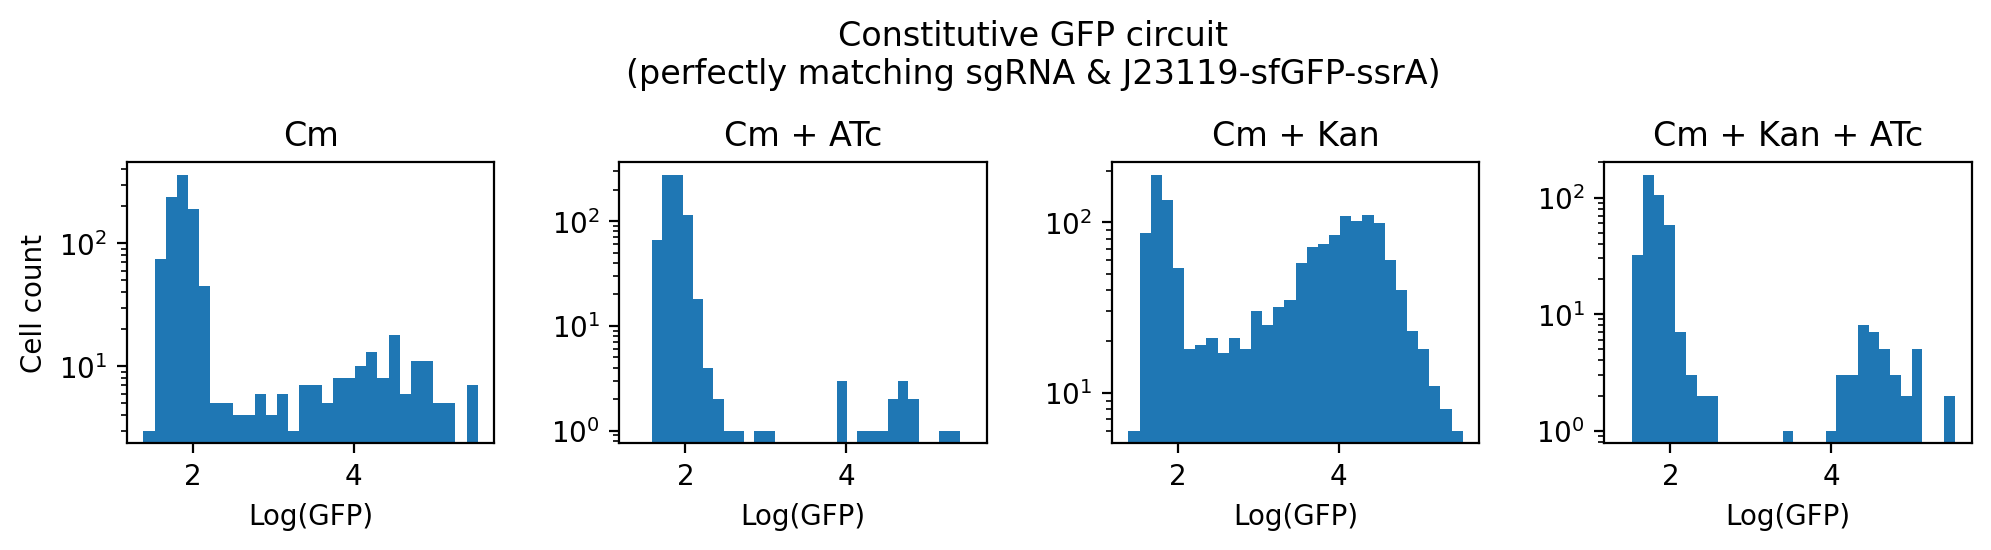

In [4]:
fig, axes = plt.subplots(1,4, figsize = (10,2), sharey = False, sharex = 'row', dpi=200)
plt.tight_layout()

for i, ax in enumerate(axes):
    combined_mean_gfp = np.array([])
    temp_direc_list = constitutive_gfp_directory_list[i*5:(i+1)*5]
    for direc in temp_direc_list:
        im_phase = skimage.io.imread('raw_images/' + direc + '/Image_CH4.tif')
        im_gfp = skimage.io.imread('raw_images/' + direc + '/Image_CH2.tif')[:,:,1]
        mean_gfp = gfp_segmenter(im_phase, im_gfp)
        combined_mean_gfp = np.concatenate([combined_mean_gfp, mean_gfp])
    ax.hist(np.log(combined_mean_gfp), 30)
    ax.set_title(direc[6:-2])
    ax.set_xlabel('Log(GFP)')
    ax.set_yscale('log')
axes[0].set_ylabel('Cell count')
axes[0].set_title('Cm')
axes[1].set_title('Cm + ATc')
axes[2].set_title('Cm + Kan')
axes[3].set_title('Cm + Kan + ATc')
fig.suptitle('Constitutive GFP circuit\n(perfectly matching sgRNA & J23119-sfGFP-ssrA)\n', va = 'bottom')

plt.show()

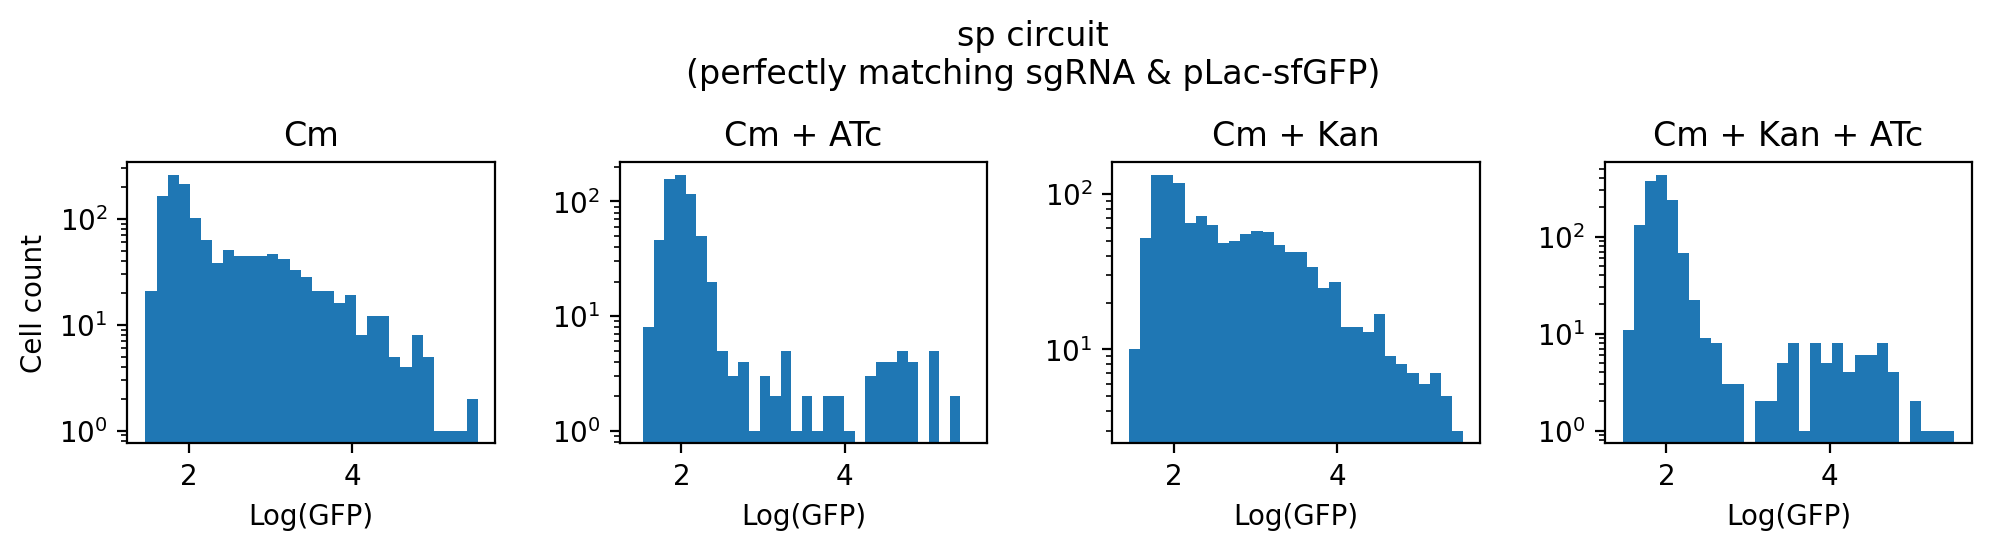

In [5]:
fig, axes = plt.subplots(1,4, figsize = (10,2), sharey = False, sharex = 'row', dpi=200)
plt.tight_layout()

for i, ax in enumerate(axes):
    combined_mean_gfp = np.array([])
    temp_direc_list = sp_directory_list[i*5:(i+1)*5]
    for direc in temp_direc_list:
        im_phase = skimage.io.imread('raw_images/' + direc + '/Image_CH4.tif')
        im_gfp = skimage.io.imread('raw_images/' + direc + '/Image_CH2.tif')[:,:,1]
        mean_gfp = gfp_segmenter(im_phase, im_gfp)
        combined_mean_gfp = np.concatenate([combined_mean_gfp, mean_gfp])
    ax.hist(np.log(combined_mean_gfp), 30)
    ax.set_title(direc[3:-2])
    ax.set_xlabel('Log(GFP)')
    ax.set_yscale('log')
axes[0].set_ylabel('Cell count')
axes[0].set_title('Cm')
axes[1].set_title('Cm + ATc')
axes[2].set_title('Cm + Kan')
axes[3].set_title('Cm + Kan + ATc')
fig.suptitle('sp circuit\n(perfectly matching sgRNA & pLac-sfGFP)\n', va = 'bottom')

plt.show()

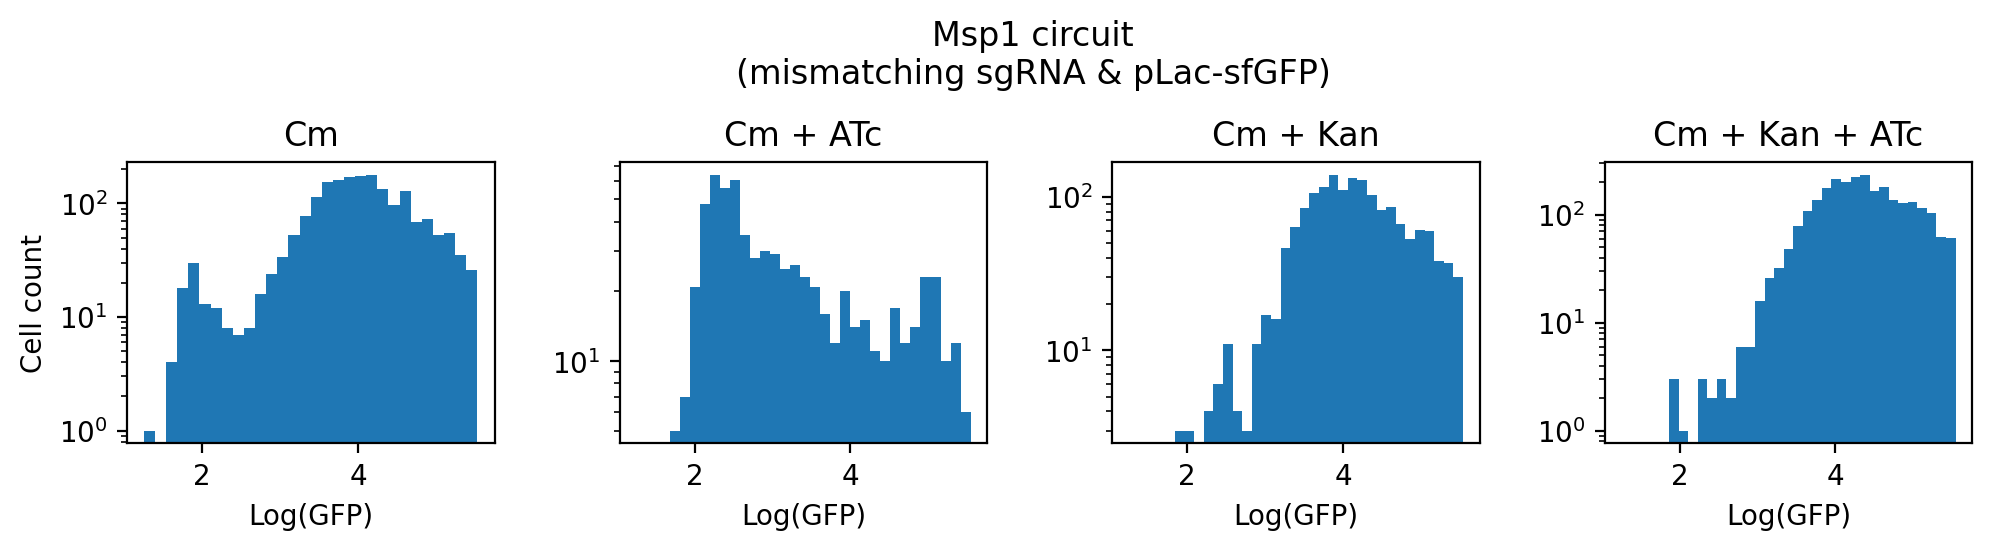

In [6]:
fig, axes = plt.subplots(1,4, figsize = (10,2), sharey = False, sharex = 'row', dpi=200)
plt.tight_layout()

for i, ax in enumerate(axes):
    combined_mean_gfp = np.array([])
    temp_direc_list = Msp1_directory_list[i*5:(i+1)*5]
    for direc in temp_direc_list:
        im_phase = skimage.io.imread('raw_images/' + direc + '/Image_CH4.tif')
        im_gfp = skimage.io.imread('raw_images/' + direc + '/Image_CH2.tif')[:,:,1]
        mean_gfp = gfp_segmenter(im_phase, im_gfp)
        combined_mean_gfp = np.concatenate([combined_mean_gfp, mean_gfp])
    ax.hist(np.log(combined_mean_gfp), 30)
    ax.set_title(direc[5:-2])
    ax.set_xlabel('Log(GFP)')
    ax.set_yscale('log')
axes[0].set_ylabel('Cell count')
axes[0].set_title('Cm')
axes[1].set_title('Cm + ATc')
axes[2].set_title('Cm + Kan')
axes[3].set_title('Cm + Kan + ATc')
fig.suptitle('Msp1 circuit\n(mismatching sgRNA & pLac-sfGFP)\n', va = 'bottom')

plt.show()